In [2]:
import torchvision
import torch

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Sqeeze(object):
    def __call__(self, sample):
        sqzd = torch.squeeze(sample)
        return sqzd
    
    def __repr__(self) -> str:
        return 'Squeze()'


In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081)),
    Sqeeze()
])

mnist_train = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)

 12%|█▏        | 1162240/9912422 [00:00<00:00, 11616899.41it/s]

9913344it [00:00, 11136224.73it/s]                             


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


29696it [00:00, 25279896.81it/s]         
  0%|          | 0/1648877 [00:00<?, ?it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



1649664it [00:00, 11265556.77it/s]                             
5120it [00:00, 16343102.34it/s]         


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [5]:
mnist_train_data = mnist_train.data
mnist_train_labels = mnist_train.targets
mnist_test_data = mnist_test.data
mnist_test_labels = mnist_test.targets

In [6]:
mnist_train_data.shape

torch.Size([60000, 28, 28])

In [6]:
# mnist_train_data_0 = mnist_train_data[mnist_train_labels == 0]
# mnist_train_data_1 = mnist_train_data[mnist_train_labels == 1]
# mnist_train_data_2 = mnist_train_data[mnist_train_labels == 2]

# mnist_test_data_0 = mnist_test_data[mnist_test_labels == 0]
# mnist_test_data_1 = mnist_test_data[mnist_test_labels == 1]
# mnist_test_data_2 = mnist_test_data[mnist_test_labels == 2]

# mnist_train_labels_0 = mnist_train_labels[mnist_train_labels == 0]
# mnist_train_labels_1 = mnist_train_labels[mnist_train_labels == 1]
# mnist_train_labels_2 = mnist_train_labels[mnist_train_labels == 2]

# mnist_test_labels_0 = mnist_test_labels[mnist_test_labels == 0]
# mnist_test_labels_1 = mnist_test_labels[mnist_test_labels == 1]
# mnist_test_labels_2 = mnist_test_labels[mnist_test_labels == 2]

In [7]:
# mnist_train_data = np.vstack([mnist_train_data_0, mnist_train_data_1, mnist_train_data_2])
# mnist_train_labels = np.hstack([mnist_train_labels_0, mnist_train_labels_1, mnist_train_labels_2])
# # mnist_train_labels = (mnist_train_labels == 8) + 0

# mnist_test_data = np.vstack([mnist_test_data_0, mnist_test_data_1, mnist_test_data_2])
# mnist_test_labels = np.hstack([mnist_test_labels_0, mnist_test_labels_1, mnist_test_labels_2])
# # mnist_test_labels = (mnist_test_labels == 8) + 0

In [8]:
mnist_train_labels

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
from torch.utils.data import TensorDataset

mnist_train_data, mnist_train_labels = torch.tensor(mnist_train_data).to(device), torch.tensor(mnist_train_labels).to(device)
mnist_test_data, mnist_test_labels = torch.tensor(mnist_test_data).to(device), torch.tensor(mnist_test_labels).to(device)

mnist_train_data = torchvision.transforms.Normalize((0.1307,), (0.3081))(mnist_train_data.float())
mnist_test_data = torchvision.transforms.Normalize((0.1307,), (0.3081))(mnist_test_data.float())

mnist_train = TensorDataset(mnist_train_data, mnist_train_labels)
mnist_test = TensorDataset(mnist_test_data, mnist_test_labels)

ipykernel_launcher:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
ipykernel_launcher:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [10]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=True)

In [11]:
for input, label in test_dataloader:
    print(input.shape)
    print(input.dtype)
    print(label.shape)
    print(label.dtype)
    break

torch.Size([32, 28, 28])
torch.float32
torch.Size([32])
torch.int64


In [20]:
import os
from main import run_model, init_model_params
from datetime import datetime
from models import GCNAuto

model_name = 'imagine_gcn_auto'
random_seed = 0
dataset_name = 'mnist'
time_now = datetime.now().strftime('%Y-%m-%d-%H-%M')
results_path = os.path.join('output', time_now, model_name, dataset_name, str(random_seed))
os.makedirs(results_path, exist_ok=True)

model = GCNAuto(in_features=28, n_nodes=28, num_classes=10, hidden_sizes=[256, 512, 256], dropout_p=0.2, device=device)

dataset_sizes = {'train': len(train_dataloader), 'val': len(test_dataloader), 'test': len(test_dataloader)}
dataloaders = {'train': train_dataloader, 'val': test_dataloader, 'test': test_dataloader}
class_names = None

In [21]:
print(dataset_sizes)
dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 1875, 'val': 313, 'test': 313}
{'train': 1875, 'val': 313}


In [22]:
model = init_model_params(model, random_seed=random_seed)
model.init_node_embeddings()
model = model.to(device)

In [24]:
from train import train_model_2

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

model, history = train_model_2(model, optimizer, scheduler, criterion, train_dataloader, test_dataloader, 10, random_seed, device)

train() called: model=GCNAuto, opt=Adam(lr=0.001000), epochs=10, device=cpu

Epoch   1/ 10, LR 0.0010, train loss: 0.1308, train acc: 0.9618, val loss: 0.1191, val acc: 0.9659
Epoch  10/ 10, LR 0.0010, train loss: 0.1083, train acc: 0.9679, val loss: 0.1490, val acc: 0.9584

Time total:     361.10 sec
Time per epoch: 36.11 sec


<AxesSubplot:>

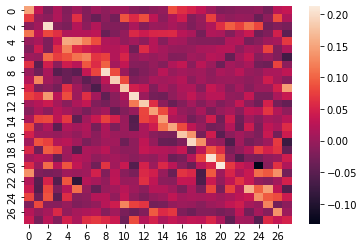

In [30]:
import seaborn as sns

adj = model.adj.detach().numpy()
sns.heatmap(adj)

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

adj_norm = scaler.fit_transform(adj)

<AxesSubplot:>

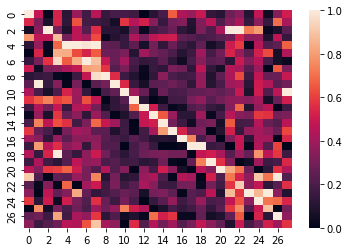

In [36]:
sns.heatmap(adj_norm)

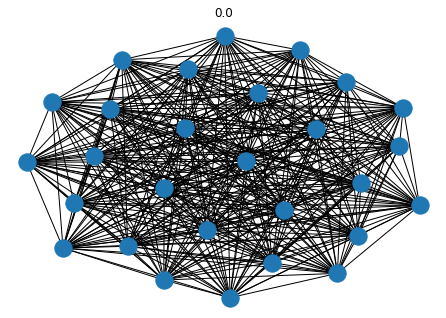

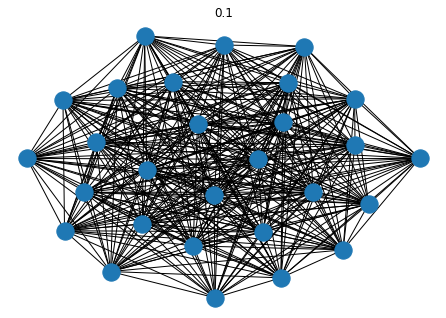

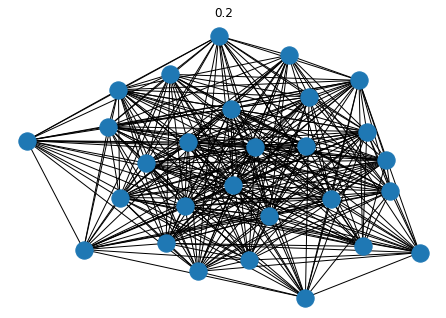

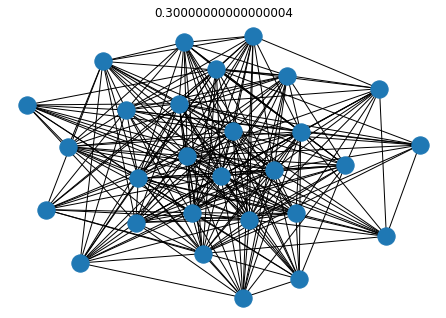

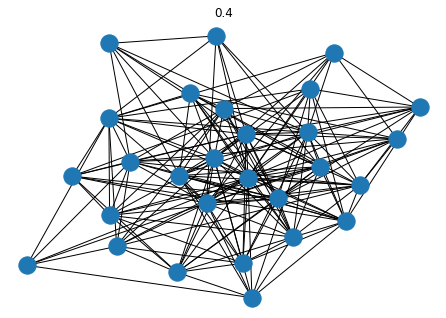

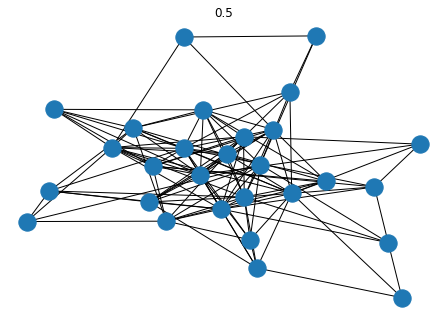

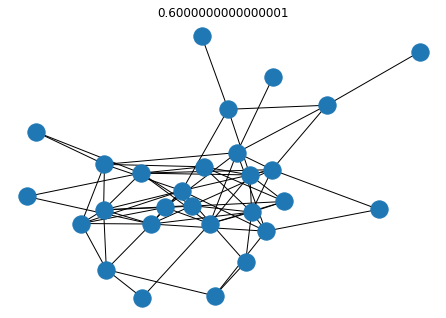

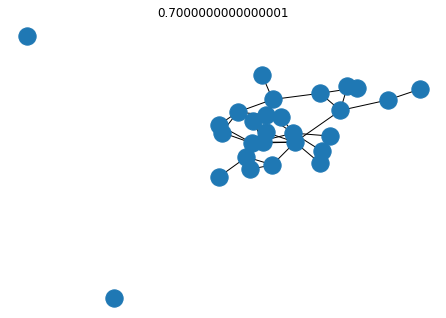

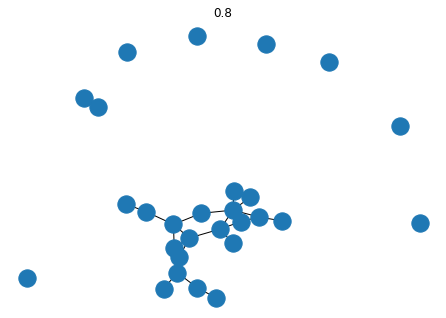

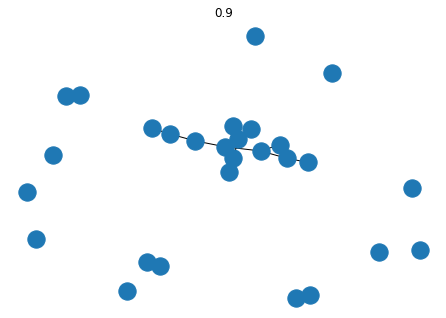

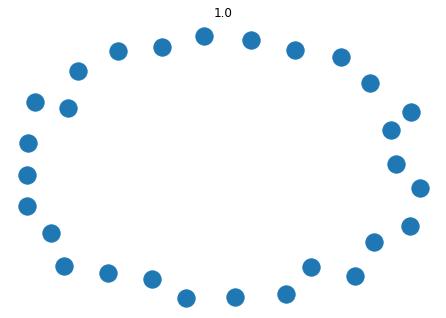

In [37]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

j = 0
for i in np.arange(0, 1.1, 0.1):
    temp = np.where(adj_norm > i, 1, 0)
    G = nx.from_numpy_matrix(temp)
    nx.draw(G)
    plt.title(i)
    plt.show()

In [61]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27))

In [62]:
fixed_positions = [(i, j) for i in range(28) for j in range(28)]
fixed_positions = {i: fixed_positions[i] for i in range(28*28)}
# print(fixed_positions)
fixed_nodes = fixed_positions.keys()
pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)
nx.draw_networkx(G, pos)

KeyError: 28

In [45]:
temp

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19],
       [20, 21],
       [22, 23],
       [24, 25],
       [26, 27],
       [ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11],
       [12, 13],
       [14, 15],
       [16, 17],
       [18, 19],
       [20, 21],
       [22, 23],
       [24, 25],
       [26, 27]])